In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime as dt
import glob
import os
import warnings
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev

warnings.filterwarnings('ignore')

In [2]:
#################################
# Make test data
# Define the structure of the data
#################################

columns = [

    "year", "month", "day", "hour", "Study_Site",

    "Burrow_mean_Temperature", "Burrow_stddev_Temperature",

    "Open_mean_Temperature", "Open_stddev_Temperature",

    "Shrub_mean_Temperature", "Shrub_stddev_Temperature",

    "DateTime", "Mean_StdDev"

]

num_rows = 8760  # Number of rows in the dataset

data = {

    "year": [2025] * num_rows,

    "month": [1] * num_rows,

    "day": [1] * num_rows,

    "hour": list(range(24)) * (num_rows // 24) + list(range(num_rows % 24)),  # Repeat hours for multiple days

    "Study_Site": ["Test_Site"] * num_rows,

    "Burrow_mean_Temperature": [25] * num_rows,

    "Burrow_stddev_Temperature": [1] * num_rows,

    "Open_mean_Temperature": [25] * num_rows,

    "Open_stddev_Temperature": [1] * num_rows,

    "Shrub_mean_Temperature": [25] * num_rows,

    "Shrub_stddev_Temperature": [1] * num_rows,

    "DateTime": pd.date_range(start="2025-01-01", periods=num_rows, freq="H"),

    "Mean_StdDev": [1] * num_rows,

}



# Ensure all columns have the same length

for key, value in data.items():

    if len(value) != num_rows:

        print(f"Column {key} length mismatch: {len(value)} vs {num_rows}")



# Create the DataFrame

df = pd.DataFrame(data)

output_path = "/home/mremington/Documents/therma_sim/therma_sim/tests/Data/thermal_db.csv"

df.to_csv(output_path, index=False)


In [31]:
otm_fp = 'Data/OTM_Main_Database.csv'
otm_data = pd.read_csv(otm_fp, index_col=0)
otm_data['Date'] = pd.to_datetime(otm_data['Date'])
otm_data = otm_data.drop(columns=['Lat', 'Long'])
# microhabitat = []
# for index, row in otm_data.iterrows():
#     if row['OTM_ID']=='Air Temperature':
#         micro = 'Air_Temperature'
#     else:
#         micro = row['Microhabitat']
#     microhabitat.append(micro)
# otm_data['Microhabitat'] = microhabitat
#otm_data = otm_data.dropna(subset=['Microhabitat']).sort_values(by=['Study_Site', 'Date'], ascending=True)
#otm_data.head()



In [27]:
unique_combinations = otm_data[['Study_Site', 'Microhabitat']].drop_duplicates()
print(unique_combinations)

       Study_Site Microhabitat
0          Canada       Burrow
14304      Canada          Air
21456      Canada         Open
42912      Canada          NaN
50064      Canada        Shrub
158066      Texas        Shrub
182642      Texas         Open
190834      Texas       Burrow
398039   Nebraska        Shrub
406231   Nebraska          Air
414423   Nebraska       Burrow
430807   Nebraska         Open


In [4]:
nan_microhabitat_rows = otm_data[otm_data['Microhabitat'].isna()]
nan_microhabitat_rows.head()#['file_name'].unique()

,Date,Unit,Temperature,year,month,day,hour,minute,Study_Site,OTM_ID,file_name,Microhabitat


In [15]:
otm_data.head()

,year,month,day,hour,Study_Site,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,NaN_mean_Temperature,NaN_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
0,2022,6,17,23,Canada,22.580,NaN,18.48650,1.632718,20.121,NaN,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00
1,2022,6,18,0,Canada,20.579,NaN,17.86075,1.034088,19.120,NaN,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00
2,2022,6,18,1,Canada,21.079,NaN,17.73575,1.094420,19.120,NaN,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00
3,2022,6,18,2,Canada,19.077,NaN,16.85950,0.661747,17.617,NaN,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00
4,2022,6,18,3,Canada,18.077,NaN,16.48375,0.499659,17.116,NaN,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00


In [32]:
spark = SparkSession.builder.appName("PandasToSparkPivot").getOrCreate()
spark_df = spark.createDataFrame(otm_data)

# Pivot the Spark DataFrame
otm_data = spark_df.groupBy('year', 'month',
                          'day','hour', 'Study_Site').pivot("Microhabitat").agg(
    mean("Temperature").alias("mean_Temperature"),
    stddev("Temperature").alias("stddev_Temperature")
)


# Display the pivoted Spark DataFrame
otm_data = otm_data.toPandas()
otm_data = otm_data.sort_values(by=['Study_Site', 'year', 'month', 'day', 'hour'], ascending=True).reset_index(drop=True)
otm_data['DateTime'] = pd.to_datetime(otm_data[['year', 'month', 'day', 'hour']])
#otm_data.drop(columns=['Air_mean_Temperature', 'Air_stddev_Temperature'], inplace=True)
columns_to_check = ['Burrow_mean_Temperature', 'Open_mean_Temperature', 'Shrub_mean_Temperature']
otm_data = otm_data.dropna(subset=columns_to_check)
# Calculate the mean of standard deviation grouped by DateTime ignoring the Study_Site
mean_stddev_by_date = otm_data.groupby(otm_data['DateTime'])['Burrow_stddev_Temperature'].mean().reset_index()
mean_stddev_by_date.columns = ['DateTime', 'Mean_StdDev']


# # Merge the mean stddev back to the original dataframe
# otm_data['Date'] = otm_data['DateTime'].dt.date
otm_data = pd.merge(otm_data, mean_stddev_by_date, on='DateTime', how='left')
# # Replace the standard deviation for the Nebraska study site
otm_data.loc[otm_data['Study_Site'] == 'Nebraska', 'Burrow_stddev_Temperature'] = otm_data['Mean_StdDev']

# # Drop the helper columns
#otm_data.drop(columns=['Date', 'Mean_StdDev','Mean_StdDev_x','Mean_StdDev_y'], inplace=True)

otm_data.head()

,year,month,day,hour,Study_Site,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,NaN_mean_Temperature,NaN_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
0,2022,6,17,23,Canada,22.580,NaN,18.48650,1.632718,20.121,NaN,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00,1.632718
1,2022,6,18,0,Canada,20.579,NaN,17.86075,1.034088,19.120,NaN,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00,1.062093
2,2022,6,18,1,Canada,21.079,NaN,17.73575,1.094420,19.120,NaN,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00,1.052493
3,2022,6,18,2,Canada,19.077,NaN,16.85950,0.661747,17.617,NaN,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00,0.904428
4,2022,6,18,3,Canada,18.077,NaN,16.48375,0.499659,17.116,NaN,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00,0.874555


In [9]:

otm_data['Study_Site'].unique()

array(['Canada'], dtype=object)

In [7]:
otm_data[otm_data['Open_mean_Temperature'].isna()].head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Half burow_mean_Temperature,Half burow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev


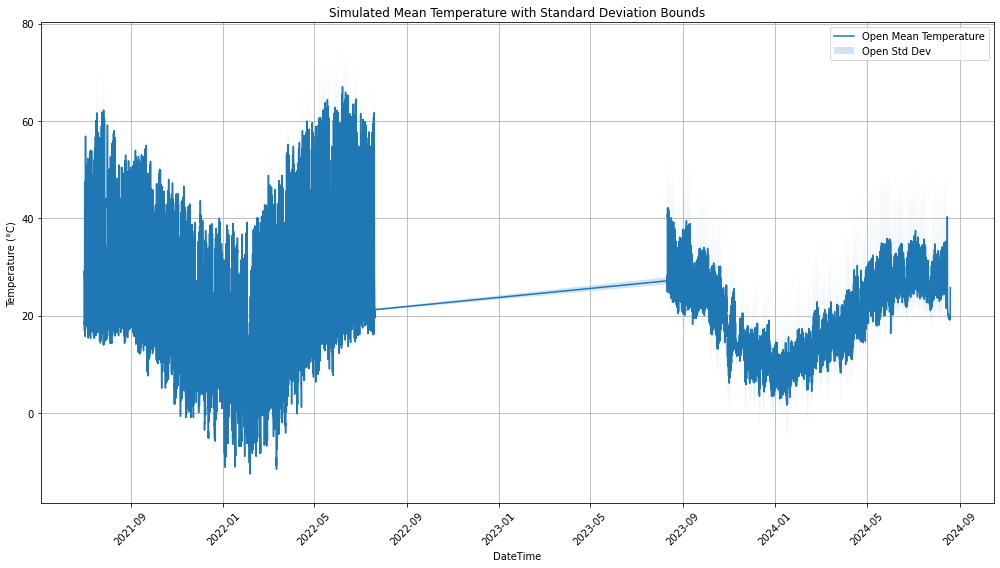

In [33]:
def plot_time_series_with_std(df, mean_col, std_col, label):
    mean = df[mean_col]
    std = df[std_col]
    plt.plot(df['DateTime'], mean, label=f"{label} Mean Temperature")
    plt.fill_between(df['DateTime'], mean - std, mean + std, alpha=0.2, label=f"{label} Std Dev")
    
start_date = '2022-06-01'
end_date = '2022-06-30'

filtered_df = otm_data[(otm_data['Study_Site'] == 'Texas')] #& 
#                  (otm_data['DateTime'] >= start_date) & 
#                  (otm_data['DateTime'] <= end_date)]

plt.figure(figsize=(14, 8))

# Plotting the simulated data
plot_time_series_with_std(filtered_df, 'Open_mean_Temperature', 'Open_stddev_Temperature', 'Open')
#plot_time_series_with_std(filtered_df, 'Burrow_mean_Temperature', 'Burrow_stddev_Temperature', 'Burrow')
#plot_time_series_with_std(filtered_df, 'Shrub_mean_Temperature', 'Shrub_stddev_Temperature', 'Shrub')


plt.xlabel('DateTime')
plt.ylabel('Temperature (°C)')
plt.title('Simulated Mean Temperature with Standard Deviation Bounds')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

In [41]:
filtered_df['Burrow_stddev_Temperature'].quantile(.75)

#0.891
#2.939

2.9393610983794862

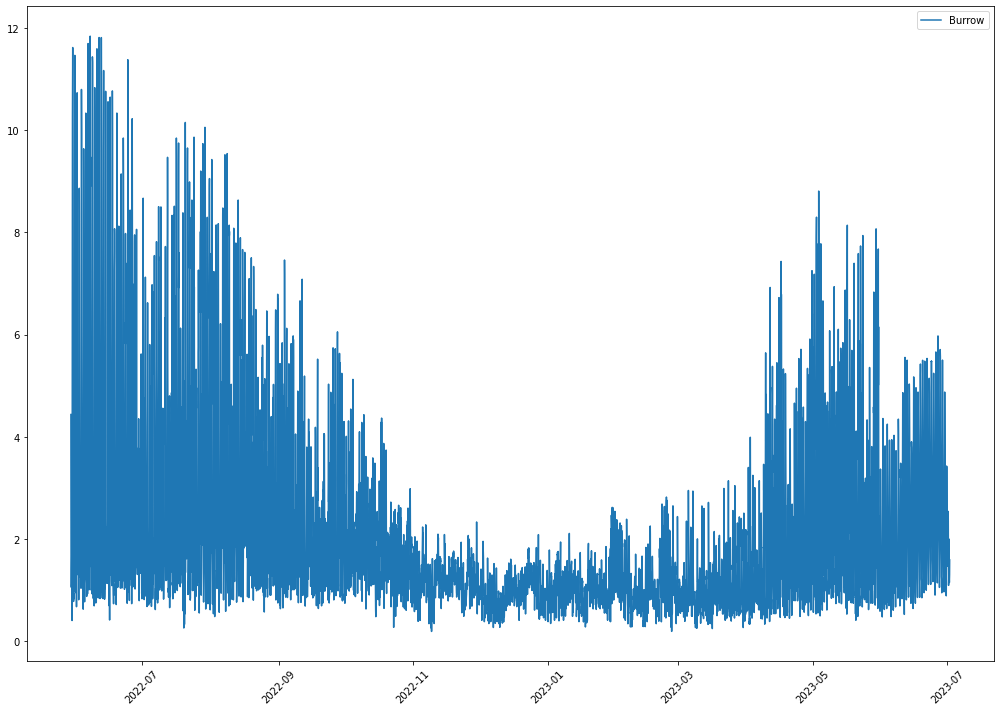

In [6]:
plt.figure(figsize=(14, 10))
#plt.plot(filtered_df['DateTime'], filtered_df['Open_stddev_Temperature'], label='Open')
plt.plot(filtered_df['DateTime'], filtered_df['Burrow_stddev_Temperature'], label='Burrow')
#plt.plot(filtered_df['DateTime'], filtered_df['Shrub_stddev_Temperature'], label='Shrub')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()

plt.show()

[Text(0.5, 1.0, 'Open: Mean Temp')]

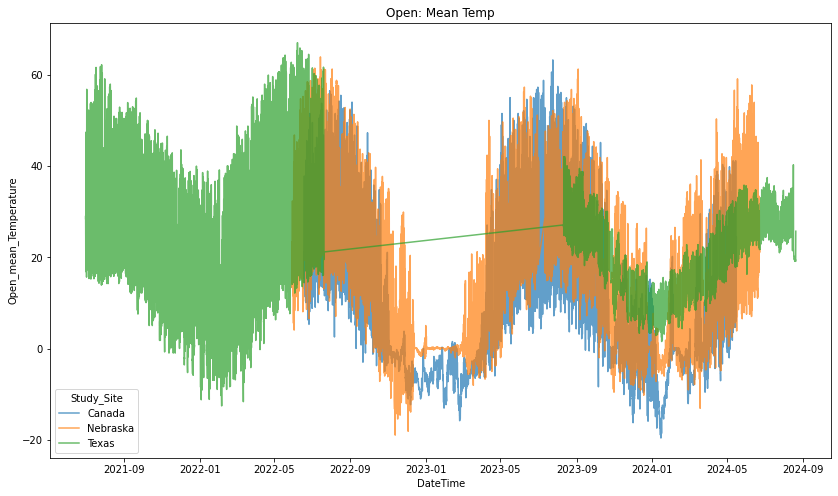

In [37]:
plt.figure(figsize=(14, 8))
column = 'Open_mean_Temperature'
label = column.split('_')[0] + ': Mean Temp'
sns.lineplot(data=otm_data, x='DateTime', y=column, hue='Study_Site', alpha=0.7).set(title=label)

In [54]:
otm_data.head()

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
0,2022,6,17,23,Canada,18.48650,1.632718,21.1220,0.004243,21.633000,0.493000,2022-06-17 23:00:00
1,2022,6,18,0,Canada,17.86075,1.034088,18.3690,0.359210,18.963333,1.035800,2022-06-18 00:00:00
2,2022,6,18,1,Canada,17.73575,1.094420,19.1205,0.004950,19.965000,0.570721,2022-06-18 01:00:00
3,2022,6,18,2,Canada,16.85950,0.661747,16.3660,0.359210,17.628000,0.859970,2022-06-18 02:00:00
4,2022,6,18,3,Canada,16.48375,0.499659,15.3645,0.359917,16.458667,0.571007,2022-06-18 03:00:00


In [38]:
from statsmodels.tsa.arima.model import ARIMA

# Fit an ARIMA model to the time series with only one sensor
model = ARIMA(otm_data['Burrow_mean_Temperature'], order=(1, 0, 0))  # AR(1) model
model_fit = model.fit()

# Use the residuals to estimate the standard deviation
estimated_stddev = np.std(model_fit.resid)
print(estimated_stddev)

1.3017814948015922


[Text(0.5, 1.0, 'Burrow Mean Temp')]

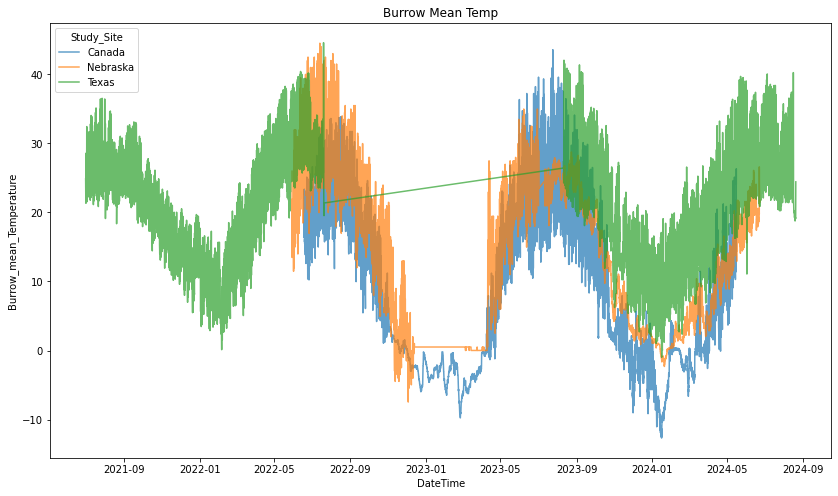

In [39]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=otm_data, x='DateTime', y='Burrow_mean_Temperature', hue='Study_Site', alpha=0.7).set(title='Burrow Mean Temp')

In [18]:

otm_data[otm_data['Study_Site'] == 'Nebraska'].head(20)

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
7152,2022,5,29,20,Nebraska,25.961,4.435334,23.3890,1.032376,22.1160,0.066468,2022-05-29 20:00:00,4.435334
7153,2022,5,29,21,Nebraska,24.461,2.496843,20.8870,1.033790,20.6155,0.065761,2022-05-29 21:00:00,2.496843
7154,2022,5,29,22,Nebraska,23.461,1.404888,19.8860,0.326683,20.1145,0.065761,2022-05-29 22:00:00,1.404888
7155,2022,5,29,23,Nebraska,13.472,1.094737,13.3740,0.376181,13.3530,0.417193,2022-05-29 23:00:00,1.094737
7156,2022,5,30,1,Nebraska,15.968,1.052268,14.3760,0.332340,13.8545,0.417900,2022-05-30 01:00:00,1.052268
7157,2022,5,30,2,Nebraska,16.467,1.118083,14.6260,0.685894,14.3555,0.417900,2022-05-30 02:00:00,1.118083
7158,2022,5,30,3,Nebraska,16.966,1.121328,14.6260,0.685894,14.6060,0.772161,2022-05-30 03:00:00,1.121328
7159,2022,5,30,4,Nebraska,16.966,1.439962,14.3760,0.332340,14.3555,0.417900,2022-05-30 04:00:00,1.439962
7160,2022,5,30,5,Nebraska,16.467,1.723898,14.3760,0.332340,14.3555,0.417900,2022-05-30 05:00:00,1.723898
7161,2022,5,30,6,Nebraska,16.467,1.817992,13.8750,0.332340,14.1050,0.063640,2022-05-30 06:00:00,1.817992


In [30]:
filtered_df.head(50)

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime
7152,2022,5,29,20,Nebraska,25.961,NaN,23.3890,1.032376,22.1160,0.066468,2022-05-29 20:00:00
7153,2022,5,29,21,Nebraska,24.461,NaN,20.8870,1.033790,20.6155,0.065761,2022-05-29 21:00:00
7154,2022,5,29,22,Nebraska,23.461,NaN,19.8860,0.326683,20.1145,0.065761,2022-05-29 22:00:00
7155,2022,5,29,23,Nebraska,13.472,NaN,13.3740,0.376181,13.3530,0.417193,2022-05-29 23:00:00
7156,2022,5,30,1,Nebraska,15.968,NaN,14.3760,0.332340,13.8545,0.417900,2022-05-30 01:00:00
7157,2022,5,30,2,Nebraska,16.467,NaN,14.6260,0.685894,14.3555,0.417900,2022-05-30 02:00:00
7158,2022,5,30,3,Nebraska,16.966,NaN,14.6260,0.685894,14.6060,0.772161,2022-05-30 03:00:00
7159,2022,5,30,4,Nebraska,16.966,NaN,14.3760,0.332340,14.3555,0.417900,2022-05-30 04:00:00
7160,2022,5,30,5,Nebraska,16.467,NaN,14.3760,0.332340,14.3555,0.417900,2022-05-30 05:00:00
7161,2022,5,30,6,Nebraska,16.467,NaN,13.8750,0.332340,14.1050,0.063640,2022-05-30 06:00:00


In [20]:
nan_microhabitat_rows = otm_data[otm_data['Burrow_stddev_Temperature'].isna()]
nan_microhabitat_rows.head()
#plt.plot(otm_data['DateTime'], nan_microhabitat_rows['Burrow_stddev_Temperature'], label='Burrow')

,year,month,day,hour,Study_Site,Burrow_mean_Temperature,Burrow_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,DateTime,Mean_StdDev
8223,2022,7,20,21,Nebraska,33.466,NaN,24.619667,2.980679,25.947667,0.620669,2022-07-20 21:00:00,NaN


In [40]:
from scipy.interpolate import Akima1DInterpolator
# Drop NaN rows and set Date as index
resampled_therma_df = otm_data.set_index("DateTime")

# Resample to 60-minute intervals grouped by Study_Site
resampled_therma_df = resampled_therma_df.groupby("Study_Site").resample("60T").mean()

# Reset index to restore Date column
resampled_therma_df = resampled_therma_df.reset_index()

columns_to_interpolate = ["Burrow_mean_Temperature", "Burrow_stddev_Temperature", "Open_mean_Temperature", "Open_stddev_Temperature"]  

# Function to apply Akima interpolation for each Study_Site group
def akima_interpolate_group(group, column_name):
    non_nan_values = group.dropna(subset=[column_name])
    
    if len(non_nan_values) > 1:
        interpolator = Akima1DInterpolator(non_nan_values.index.astype(int), non_nan_values[column_name])
        group[column_name] = group[column_name].fillna(pd.Series(interpolator(group.index.astype(int)), index=group.index))
    
    return group
columns_to_interpolate = ["Burrow_mean_Temperature", "Burrow_stddev_Temperature", "Open_mean_Temperature", "Open_stddev_Temperature"] 
# Apply Akima interpolation only to numeric columns
for col in columns_to_interpolate:
    resampled_therma_df = resampled_therma_df.groupby("Study_Site", group_keys=False).apply(lambda g: akima_interpolate_group(g, col))

# Forward-fill Study_Site column
resampled_therma_df["Study_Site"] = resampled_therma_df["Study_Site"].ffill()


resampled_therma_df["DateTime"] = pd.to_datetime(resampled_therma_df["DateTime"])
resampled_therma_df["year"] = resampled_therma_df["DateTime"].dt.year
resampled_therma_df["month"] = resampled_therma_df["DateTime"].dt.month
resampled_therma_df["day"] = resampled_therma_df["DateTime"].dt.day
resampled_therma_df["hour"] = resampled_therma_df["DateTime"].dt.hour

In [41]:
resampled_therma_df.head()

,Study_Site,DateTime,year,month,day,hour,Air_mean_Temperature,Air_stddev_Temperature,Burrow_mean_Temperature,Burrow_stddev_Temperature,NaN_mean_Temperature,NaN_stddev_Temperature,Open_mean_Temperature,Open_stddev_Temperature,Shrub_mean_Temperature,Shrub_stddev_Temperature,Mean_StdDev
0,Canada,2022-06-17 23:00:00,2022,6,17,23,22.580,NaN,18.48650,1.632718,20.121,NaN,21.1220,0.004243,21.633000,0.493000,1.632718
1,Canada,2022-06-18 00:00:00,2022,6,18,0,20.579,NaN,17.86075,1.034088,19.120,NaN,18.3690,0.359210,18.963333,1.035800,1.062093
2,Canada,2022-06-18 01:00:00,2022,6,18,1,21.079,NaN,17.73575,1.094420,19.120,NaN,19.1205,0.004950,19.965000,0.570721,1.052493
3,Canada,2022-06-18 02:00:00,2022,6,18,2,19.077,NaN,16.85950,0.661747,17.617,NaN,16.3660,0.359210,17.628000,0.859970,0.904428
4,Canada,2022-06-18 03:00:00,2022,6,18,3,18.077,NaN,16.48375,0.499659,17.116,NaN,15.3645,0.359917,16.458667,0.571007,0.874555


[Text(0.5, 1.0, 'Open: Mean Temp')]

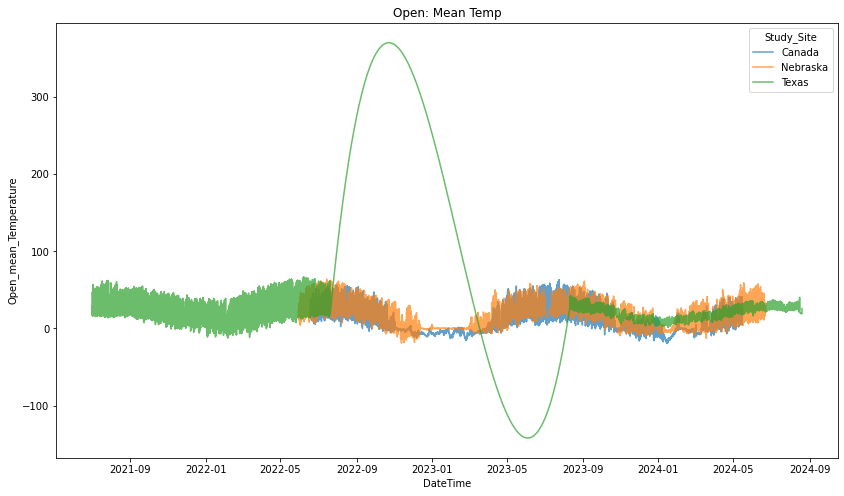

In [43]:
plt.figure(figsize=(14, 8))
column = 'Open_mean_Temperature'
label = column.split('_')[0] + ': Mean Temp'
sns.lineplot(data=resampled_therma_df, x='DateTime', y=column, hue='Study_Site', alpha=0.7).set(title=label)

In [53]:
## Get only last year

resampled_therma_df['DateTime'] = pd.to_datetime(resampled_therma_df['DateTime'])

# Create an empty DataFrame for the filtered results
filtered_data = pd.DataFrame()

# Process each study site independently
for site, site_df in resampled_therma_df.groupby('Study_Site'):
    # Sort the dataset by DateTime to ensure proper indexing
    site_df = site_df.sort_values(by="DateTime").reset_index(drop=True)
    
    # Get the index of the latest timestamp
    latest_idx = site_df.index[-1]  # Last row index
    
    # Calculate the starting index for the last 365 days
    start_idx = max(0, latest_idx - (24 * 365))  # Ensures we don't go below index 0

    # Slice the DataFrame to get the last 365 days of data
    site_filtered = site_df.iloc[start_idx:]

    # Append results to the final DataFrame
    filtered_data = pd.concat([filtered_data, site_filtered])

[Text(0.5, 1.0, 'Open: Mean Temp')]

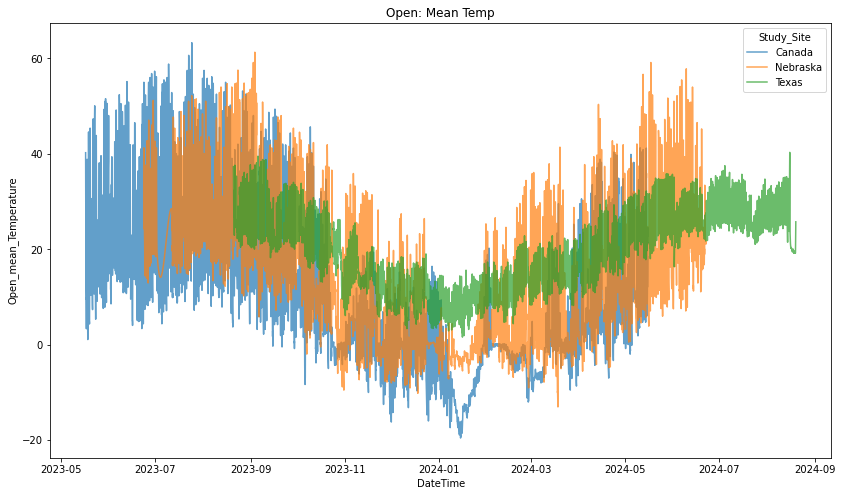

In [54]:
plt.figure(figsize=(14, 8))
column = 'Open_mean_Temperature'
label = column.split('_')[0] + ': Mean Temp'
sns.lineplot(data=filtered_data, x='DateTime', y=column, hue='Study_Site', alpha=0.7).set(title=label)

In [67]:
# Number of years to append
num_years = 11

# Create an empty DataFrame to store the results
appended_data = pd.DataFrame()

for i in range(num_years):
    # Create a copy of the dataset
    temp_df = filtered_data.copy()
    
    # Update the year
    temp_df['year'] += i  # Increment year by the iteration number
    
    # Update the DateTime column
    temp_df['DateTime'] = pd.to_datetime(temp_df['DateTime']) + pd.DateOffset(years=i)
    
#     # Add new temperature columns for the increment
#     temp_df[f'open_plus_{i+1}'] = temp_df['Open_mean_Temperature'] + (i + 1)
#     temp_df[f'burrow_plus_{i+1}'] = temp_df['Burrow_mean_Temperature'] + (i + 1)
    
    # Append to the new DataFrame
    appended_data = pd.concat([appended_data, temp_df], ignore_index=True)


In [68]:
# Drop duplicate rows across the entire DataFrame
appended_data = appended_data.drop_duplicates()

# Alternatively, drop duplicates based on specific columns
appended_data = appended_data.drop_duplicates(subset=['year', 'month', 'day', 'hour', 'Study_Site'])

# Reset index after dropping duplicates (optional)
appended_data = appended_data.reset_index(drop=True)

[Text(0.5, 1.0, 'Open Mean Temp (Nebraska)')]

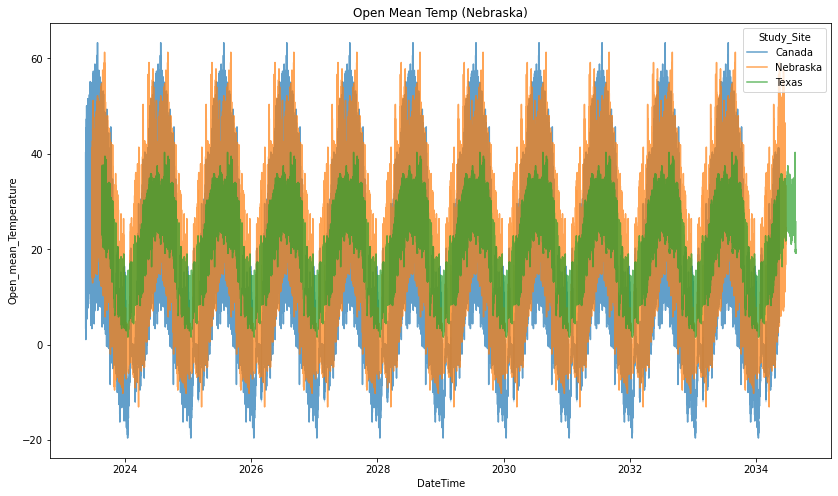

In [69]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=appended_data,
             x='DateTime',
             y='Open_mean_Temperature',
             hue='Study_Site', alpha=0.7).set(title='Open Mean Temp (Nebraska)') 

In [64]:
# Make Experimental Groups
appended_data[f'open_plus_1'] = appended_data['Open_mean_Temperature'] + 1
appended_data[f'burrow_plus_1'] = appended_data['Burrow_mean_Temperature'] + 1
appended_data[f'open_plus_2'] = appended_data['Open_mean_Temperature'] + 2
appended_data[f'burrow_plus_2'] = appended_data['Burrow_mean_Temperature'] + 2
appended_data[f'open_plus_3'] = appended_data['Open_mean_Temperature'] + 3
appended_data[f'burrow_plus_3'] = appended_data['Burrow_mean_Temperature'] + 3

[Text(0.5, 1.0, 'Open Mean Temp (Canada)')]

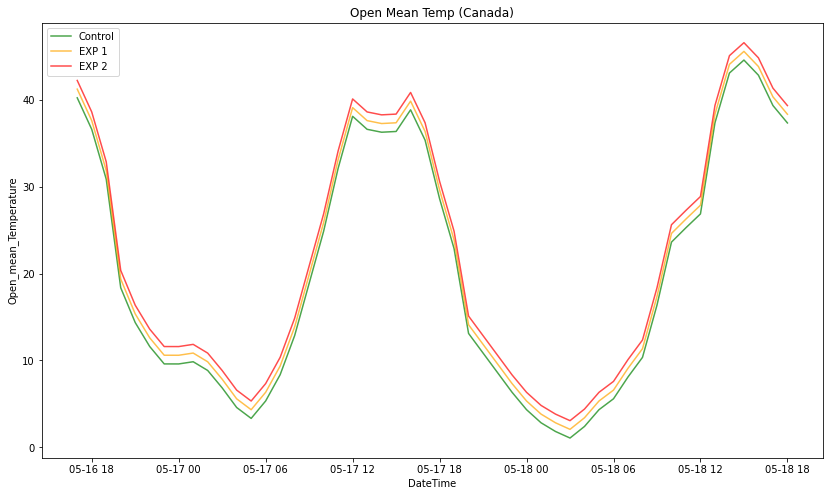

In [65]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=appended_data[appended_data['Study_Site'] == 'Canada'][0:50],
             x='DateTime',
             y='Open_mean_Temperature',
             alpha=0.7,
             color='green',
             label='Control').set(title='Open Mean Temp (Canada)') 
sns.lineplot(data=appended_data[appended_data['Study_Site'] == 'Canada'][0:50],
             x='DateTime',
             y='open_plus_1',
             color='orange',
             label='EXP 1',
             alpha=0.7).set(title='Open Mean Temp (Canada)')
sns.lineplot(data=appended_data[appended_data['Study_Site'] == 'Canada'][0:50],
             x='DateTime',
             y='open_plus_2',
             color='red',
             label='EXP 2',
             alpha=0.7).set(title='Open Mean Temp (Canada)') 

In [70]:
# # Drop NA values
# otm_data.dropna(inplace=True)

# Sort the DataFrame by Study_Site and DateTime
appended_data.sort_values(by=['Study_Site', 'DateTime'], inplace=True)

# Save each Study_Site to a separate CSV file
study_sites = appended_data['Study_Site'].unique()
for site in study_sites:
    site_data = appended_data[appended_data['Study_Site'] == site]
    site_data.to_csv(f'Data/{site}_data_{num_years}_years.csv', index=False)